# Noise2Void - 2D Example

In [1]:
%load_ext autoreload
%autoreload 2
from csbdeep.models import Config, CARE
import numpy as np
from csbdeep.utils import plot_some, plot_history
from csbdeep.utils.n2v_utils import manipulate_val_data

from matplotlib import pyplot as plt

import urllib

import os
import zipfile
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
from skimage.segmentation import find_boundaries

In [3]:
def add_boundary_label(lbl, dtype=np.uint16):
    """ lbl is an integer label image (not binarized) """
    b = find_boundaries(lbl,mode='outer')
    res = (lbl>0).astype(dtype)
    res[b] = 2
    return res


def onehot_encoding(lbl, n_classes=3, dtype=np.uint32):
    """ n_classes will be determined by max lbl value if its value is None """
    from keras.utils import to_categorical
    onehot = np.zeros((*lbl.shape, n_classes), dtype=dtype)
    for i in range(n_classes):
        onehot[lbl == i, ..., i] = 1
    return onehot



In [4]:
train_data = np.load('/home/tbuchhol/FSjuglab/starvoid/StarVoid/train_data/TrainVal.npz')
test_data = np.load('/home/tbuchhol/FSjuglab/starvoid/StarVoid/test_data/Test.npz')

In [5]:
def cutHalf(data, repeat):
    data_=data
    print(data_.shape)
    for i in range(repeat):
        newsize=int(data_.shape[1]/2)
        a=data_[:,:newsize,:]
        b=data_[:,newsize:,:]
  #      print(a.shape,b.shape)
        data_=np.concatenate((a,b), axis=0)

        newsize=int(data_.shape[2]/2)
        a=data_[:,:,:newsize]
        b=data_[:,:,newsize:]
        data_=np.concatenate((a,b), axis=0)
        print(data_.shape)
    return data_

In [6]:
# We need to normalize the data before we feed it into our network, and denormalize it afterwards.
def normalize(img, mean, std):
    zero_mean = img - mean
    return zero_mean/std

def denormalize(x, mean, std):
    return x*std + mean

In [7]:
def plot_Y(Y, idx):
    if len(Y.shape) == 4:
        plt.figure(figsize=(25,5))
        for i in range(Y.shape[-1]):
            plt.subplot(1,Y.shape[-1],i+1)
            plt.imshow(Y[idx,...,i])
            print(np.min(Y[idx,...,i]), np.max(Y[idx,...,i]))
    else:
        plt.figure(figsize=(5,5))
        plt.imshow(Y[idx,...])

In [8]:
X_train = train_data['X_train'].astype(np.float32)
Y_train = train_data['Y_train'].astype(np.float32)
X_val = cutHalf(train_data['X_val'][:640, :640], 2).astype(np.float32)
Y_val = cutHalf(train_data['Y_val'][:640, :640], 2).astype(np.float32)
X_test = test_data['X_test'].astype(np.float32)
Y_test = test_data['Y_test'].astype(np.float32)
mean, std = np.mean(X_train), np.std(X_train)
X_train = normalize(X_train, mean, std)
# Y = normalize(Y, mean, std)
X_val = normalize(X_val, mean, std)
# Y_val = normalize(Y_val, mean, std)
X_test = normalize(X_test, mean, std)

(18, 640, 736)
(72, 320, 368)
(288, 160, 184)
(18, 640, 736)
(72, 320, 368)
(288, 160, 184)


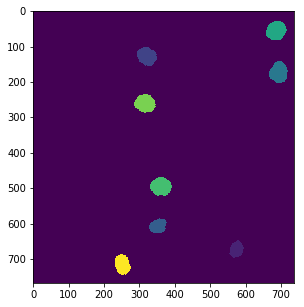

In [9]:
plot_Y(Y_train, 0)

In [10]:
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

(102, 768, 736) (102, 768, 736) (288, 160, 184) (288, 160, 184) (30, 773, 739) (30, 773, 739)


In [11]:
def convert_to_oneHot(data):
    data_oneHot = np.zeros((*data.shape, 3), dtype=np.float32)
    for i in range(data.shape[0]):
        data_oneHot[i] = onehot_encoding(add_boundary_label(data[i].astype(np.int32)))
#         data_oneHot[i] = add_boundary_label(data[i])[...,np.newaxis]
    return data_oneHot

In [12]:
Y_train_oneHot = convert_to_oneHot(Y_train)
Y_val_oneHot = convert_to_oneHot(Y_val)
Y_test_oneHot = convert_to_oneHot(Y_test)

0.0 1.0
0.0 1.0
0.0 1.0


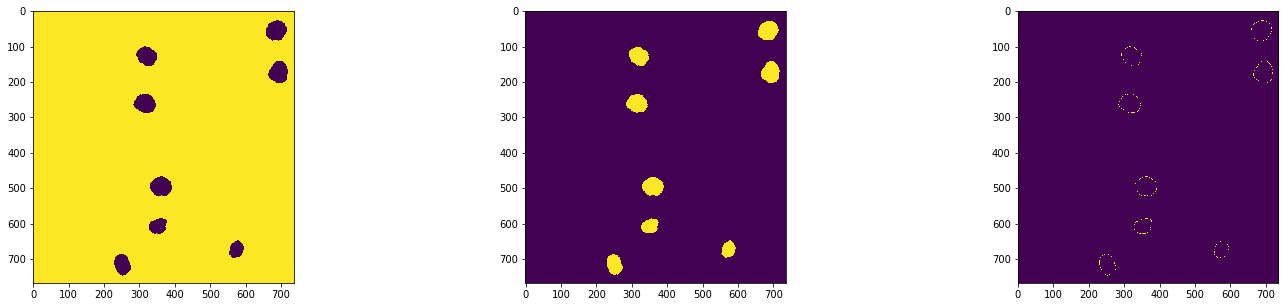

In [13]:
plot_Y(Y_train_oneHot, 0)

In [14]:
Y_train_oneHot.dtype

dtype('float32')

In [15]:
Y_train_oneHot.shape

(102, 768, 736, 3)

In [16]:
Y_train = np.concatenate((X_train[..., np.newaxis], np.zeros(X_train.shape, dtype=np.float32)[...,np.newaxis], Y_train_oneHot), axis=3)

In [17]:
Y_train.dtype

dtype('float32')

-2.2962077 20.887285
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0


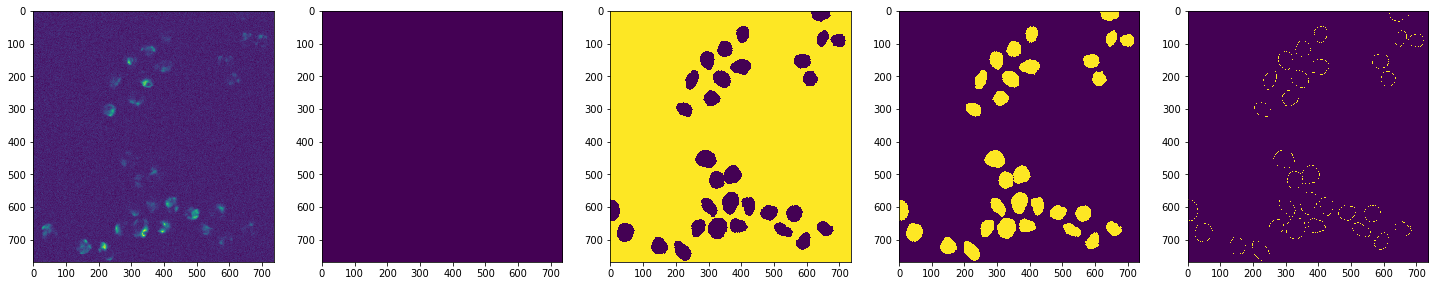

In [18]:
plot_Y(Y_train, 15)

In [19]:
X_validation = X_val[...,np.newaxis]
Y_validation = Y_val[...,np.newaxis]

In [20]:
# 1. Option
Y_validation = np.concatenate((X_validation.copy(), np.zeros(X_validation.shape, dtype=np.float32)), axis=3) 
manipulate_val_data(X_validation, Y_validation, num_pix=160*160/64 , shape=(160, 160))

/home/tbuchhol/GitRepos/StarVoid/noise2seg/csbdeep/utils/n2v_utils.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return patch[slices]


In [21]:
Y_validation.shape

(288, 160, 184, 2)

In [22]:
Y_validation = np.concatenate((Y_validation, Y_val_oneHot), axis=3)

-2.0008764 3.019752
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


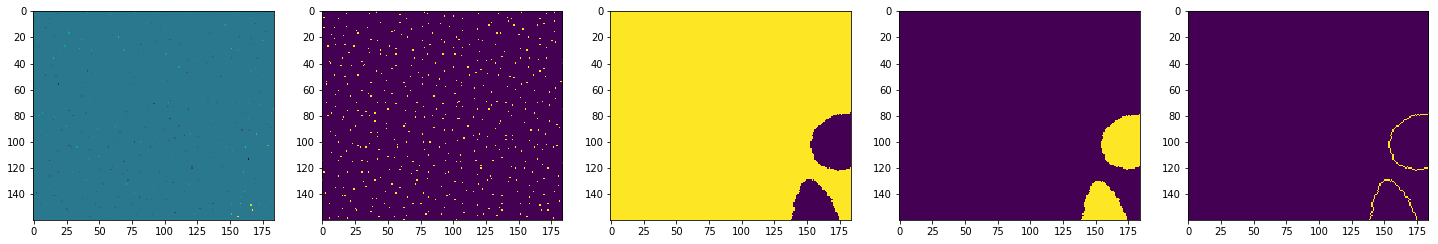

In [23]:
plot_Y(Y_validation, 150)

In [24]:
from csbdeep.internals.train import Noise2VoidDataWrapper 
from csbdeep.utils.n2v_utils import pm_uniform_withCP

In [25]:
dw = Noise2VoidDataWrapper(X_train[..., np.newaxis], Y_train, 2, num_pix=64, shape=(64,64), value_manipulation=pm_uniform_withCP(5))

In [26]:
batch = dw.__getitem__(0)

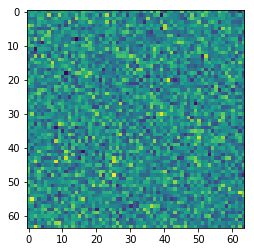

In [27]:
plt.imshow(batch[0][0,...,0])

-1.705545425415039 1.100100040435791
0.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0


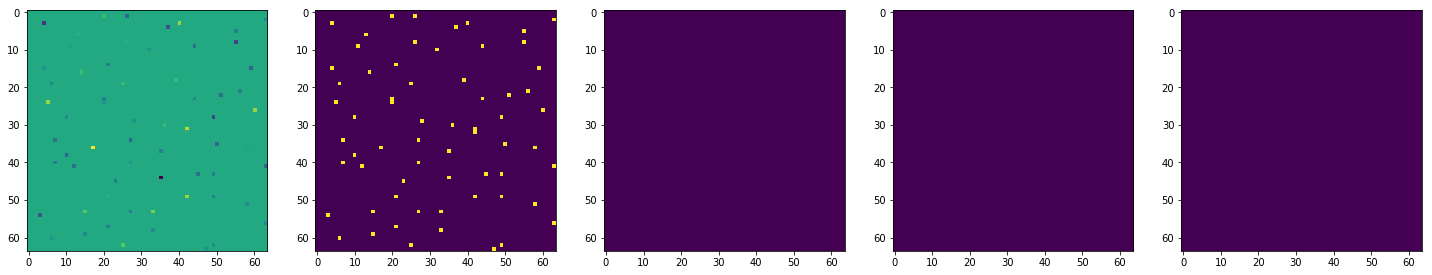

In [28]:
plot_Y(batch[1],0)

## Configure

To use Noise2Void with the CARE framework we have to switch the <code>train_scheme</code> from <code>'CARE'</code> to <code>'Noise2Void'</code>. This will turn on the pixel-masking which is needed for Noise2Void training. Furhtermore it is recommended to increase the <code>train_batch_size</code> and enable <code>batch_norm</code>. 

To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 1.6% of the input pixels per patch. For a patch size of 64 by 64 pixels we manipulated <code>n2v_num_pix</code> = 64 pixels simultaniously. 

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

In [54]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = Config('SYXC', n_channel_in=1, n_channel_out=4, unet_kern_size = 3, train_steps_per_epoch=100, train_loss='mse',
                train_epochs=10,
                batch_norm = True, train_scheme = 'Noise2Void', train_batch_size = 128, n2v_num_pix = 64,
                n2v_patch_shape = (64, 64), n2v_manipulator = 'uniform_withCP', n2v_neighborhood_radius='5', use_denoising=1)

vars(config)

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'probabilistic': False,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 10,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0},
 'batch_norm': True,
 'train_scheme': 'Noise2Void',
 'n2v_num_pix': 64,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': '5',
 'use_denoising': 1}

In [55]:
model = CARE(config, 'n2s_testing', basedir='models')

## Training Data Preparation

For training we load __one__ set of low-SNR images and normalize them to 0-mean and 1-std. This data is used as input data and stored in the variable <code>X</code>. Our target <code>Y</code> is <code>X</code> concatenated with a zero-tensor of the same shape. This zero-tensor is used for the masking of the pixels during training. 

### Validation Data Preparation

There are two possiblities to build the validation set:

1. Training-Data like: Meaning that the validations loss is only computed on a fixed number of manipulated (masked) pixels. This means that we randomly select a fixed number of pixels before training and manipulate them like it is done for the training data during training. 
2. Test-Data like: Meaning that the validation loss is computed on all pixels of the validation set.
The pixels are __not__ manipulated.
This setup is more like the setup during testing.

In our paper we chose *option 1* to have the same loss during validation as during training. But using *option 2* will result in a more stable validation loss since it is computed over __all__ instead of a subset of pixels.

## Training

In [56]:
print(X_train[..., np.newaxis].shape, Y_train.shape, X_validation.shape, Y_validation.shape)

(102, 768, 736, 1) (102, 768, 736, 5) (288, 160, 184, 1) (288, 160, 184, 5)


In [57]:
def print_stats(img):
    print(np.mean(img), np.std(img))

In [58]:
print_stats(X_train)

-9.40543e-06 0.9999998


In [59]:
print_stats(X_validation)

-0.030269269 0.8886891


-2.4438732 22.806936
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0


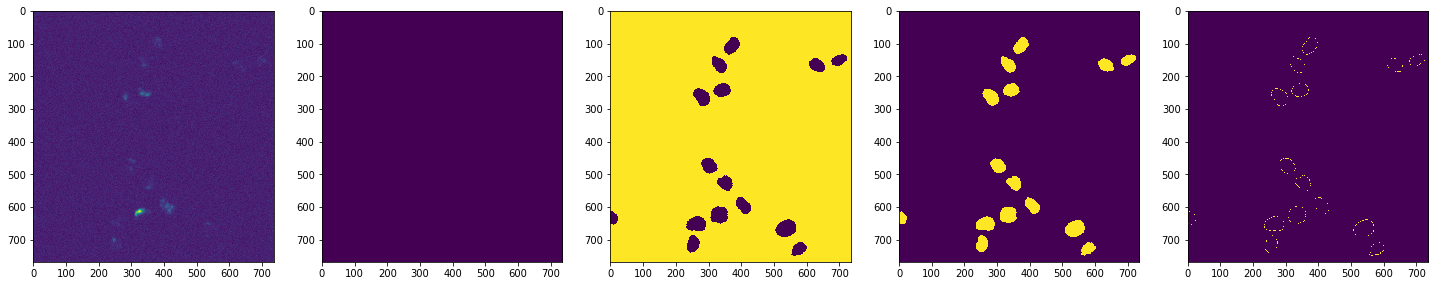

In [60]:
plot_Y(Y_train, 10)

In [61]:
X_test.dtype

dtype('float32')

In [62]:
history = model.train(X_train[..., np.newaxis],Y_train, validation_data=(X_validation,Y_validation))

Epoch 1/10
100/100 [==============================] - 46s 456ms/step - loss: 1.1406 - mse: 0.8425 - mae: 0.3595 - val_loss: 0.7904 - val_mse: 0.9354 - val_mae: 0.3089
Epoch 2/10
100/100 [==============================] - 42s 420ms/step - loss: 0.6458 - mse: 0.7627 - mae: 0.2984 - val_loss: 0.5823 - val_mse: 0.5861 - val_mae: 0.2172
Epoch 3/10
100/100 [==============================] - 41s 415ms/step - loss: 0.5019 - mse: 0.8204 - mae: 0.2784 - val_loss: 0.4673 - val_mse: 0.3884 - val_mae: 0.1767
Epoch 4/10
100/100 [==============================] - 41s 410ms/step - loss: 0.4423 - mse: 0.7447 - mae: 0.2615 - val_loss: 0.3925 - val_mse: 0.4491 - val_mae: 0.1721
Epoch 5/10
100/100 [==============================] - 42s 417ms/step - loss: 0.4213 - mse: 0.7613 - mae: 0.2573 - val_loss: 0.3690 - val_mse: 0.4341 - val_mae: 0.1913
Epoch 6/10
100/100 [==============================] - 41s 411ms/step - loss: 0.4032 - mse: 0.7632 - mae: 0.2568 - val_loss: 0.3482 - val_mse: 0.4532 - val_mae: 0.187

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


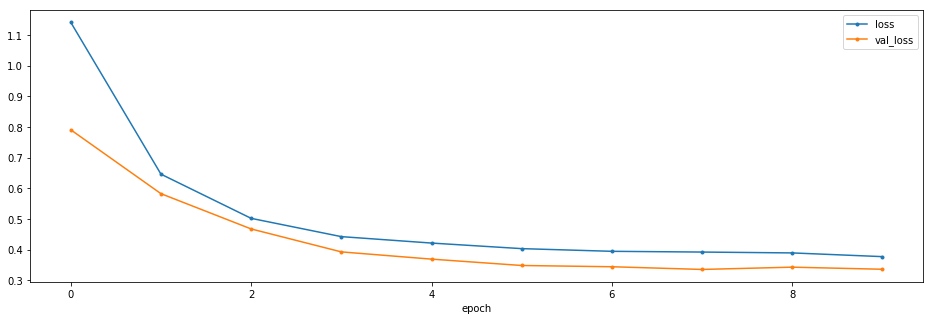

In [63]:
# Lets look at the training and validation loss.

print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [81]:
model.load_weights('/home/tbuchhol/falcon/StarVoid/outdata/sv_testing_noAug_withDenoising/train_100/sv_model/weights_best.h5')

In [82]:
pred =  model.predict(X_train[0], 'YX', normalizer=None)

In [83]:
X_train.shape

(102, 768, 736)

In [84]:
X_validation.shape

(288, 160, 184, 1)

In [85]:
pred.shape

(768, 736, 4)

In [86]:
denoised = pred[...,0]

In [87]:
seg_exp = np.exp(pred[...,1:])

seg = seg_exp/np.sum(seg_exp, axis=2)[..., np.newaxis]

In [97]:
Y_ = Y_train.copy()
Y_train_aug = np.concatenate((Y_train, np.rot90(Y_, 2, (1, 2))))
Y_train_aug = np.concatenate((Y_train_aug, np.flip(Y_train_aug, axis=1), np.flip(Y_train_aug, axis=2)))

In [98]:
Y_train_aug.shape

(612, 768, 736, 5)

-2.2962077 32.700527
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0
-2.2962077 23.98826
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0
-2.2962077 36.539833
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0
-2.2962077 21.625612
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0
-2.5915387 18.967632
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0
-2.2962077 8.9263735
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0
-2.2962077 34.915512
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0


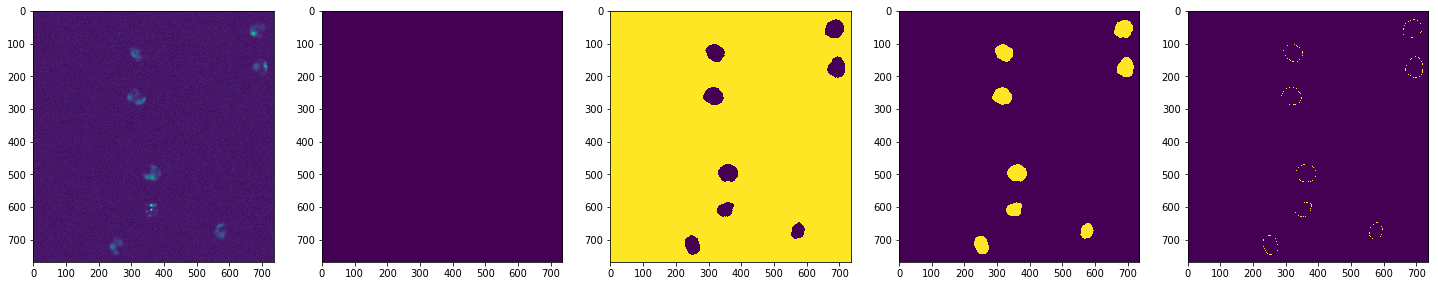

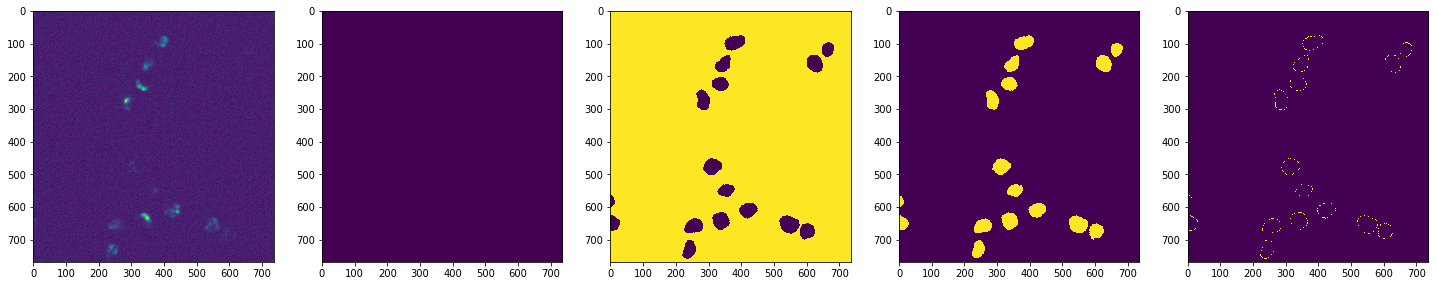

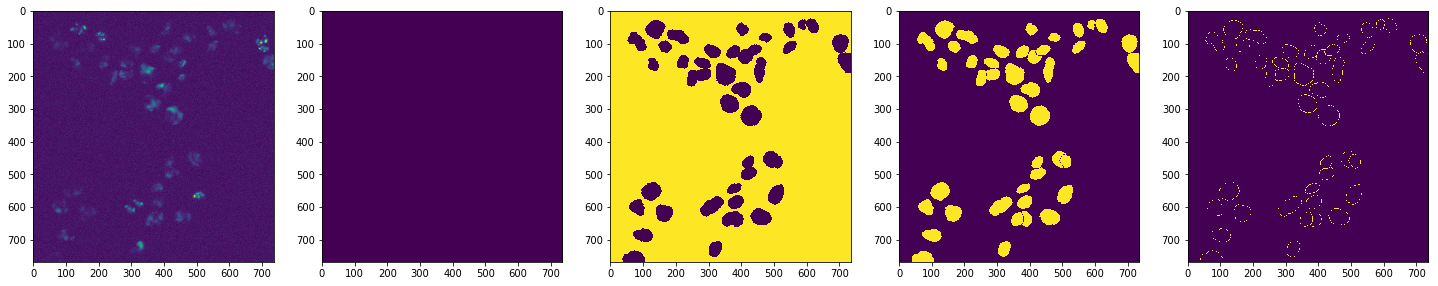

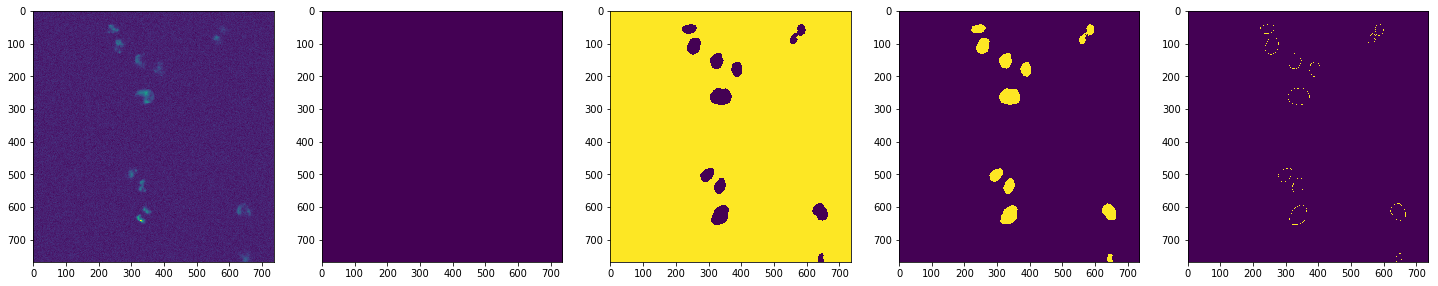

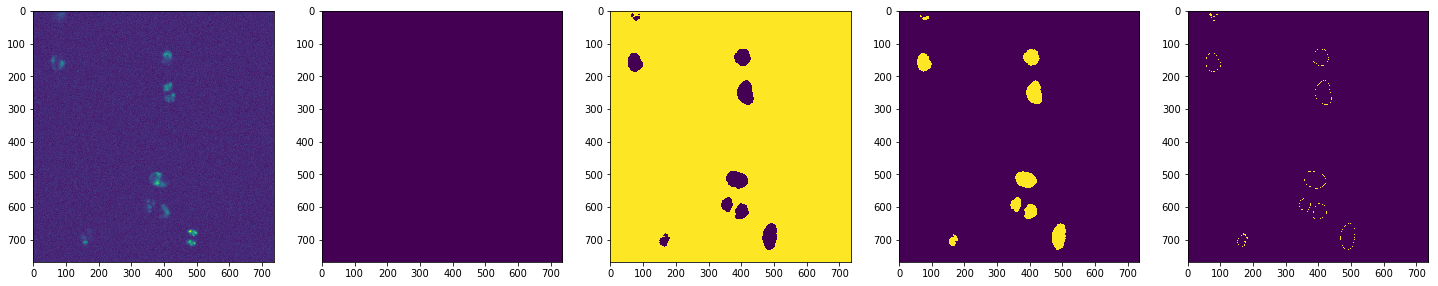

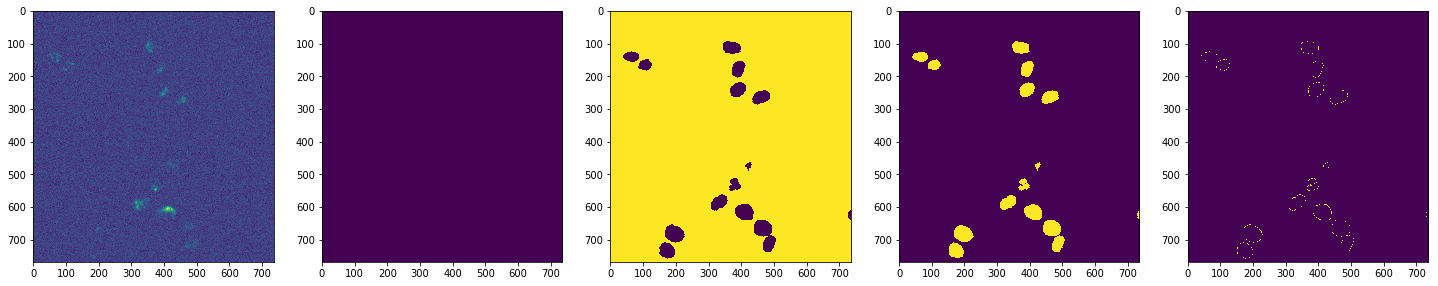

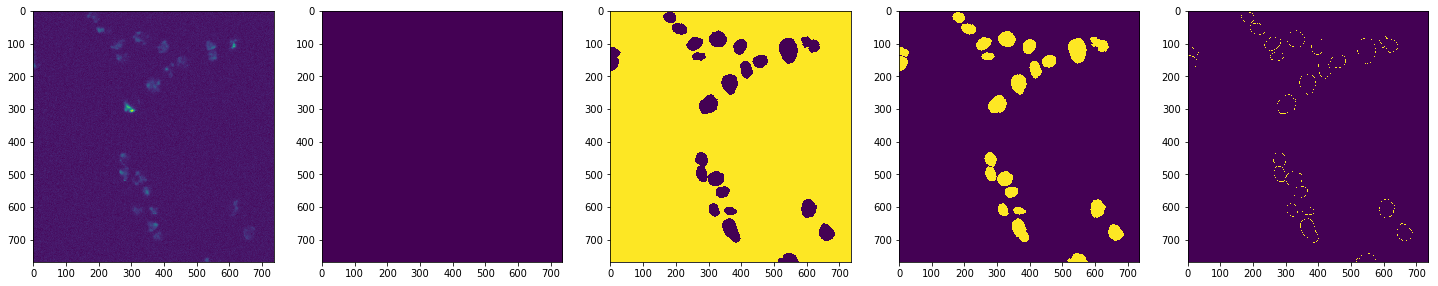

In [99]:
for i in range(0,601,100):
    plot_Y(Y_train_aug,i)

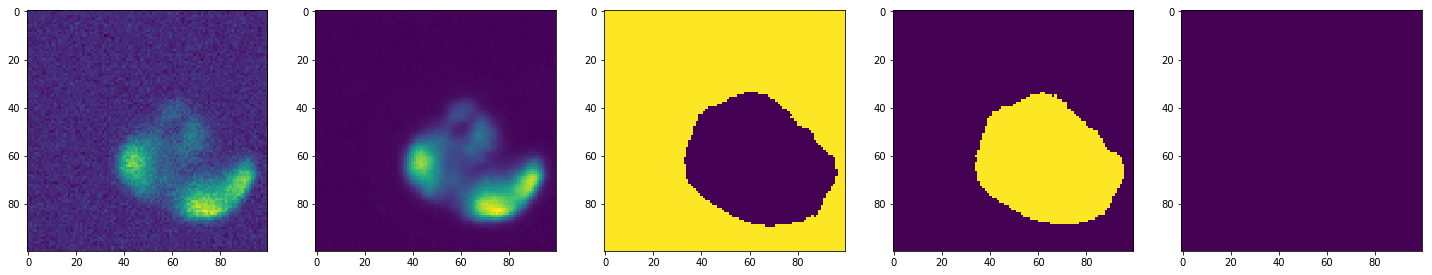

In [88]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(Y_train[0,200:300,250:350,0])
plt.subplot(1,5,2)
plt.imshow(denoised[200:300,250:350])
plt.subplot(1,5,3)
plt.imshow(seg[200:300,250:350,0]>0.5)
plt.subplot(1,5,4)
plt.imshow(seg[200:300,250:350,1]>0.5)
plt.subplot(1,5,5)
plt.imshow(seg[200:300,250:350,2]>0.5)

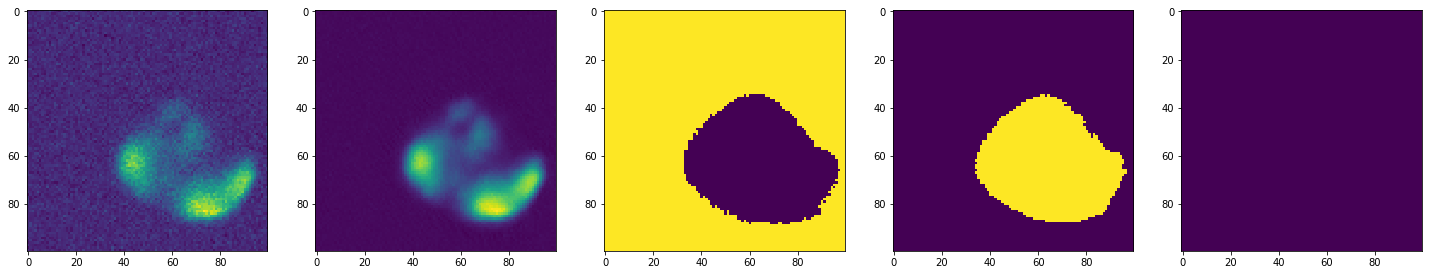

In [70]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(Y_train[0,200:300,250:350,0])
plt.subplot(1,5,2)
plt.imshow(denoised[200:300,250:350])
plt.subplot(1,5,3)
plt.imshow(seg[200:300,250:350,0]>0.5)
plt.subplot(1,5,4)
plt.imshow(seg[200:300,250:350,1]>0.5)
plt.subplot(1,5,5)
plt.imshow(seg[200:300,250:350,2]>0.5)

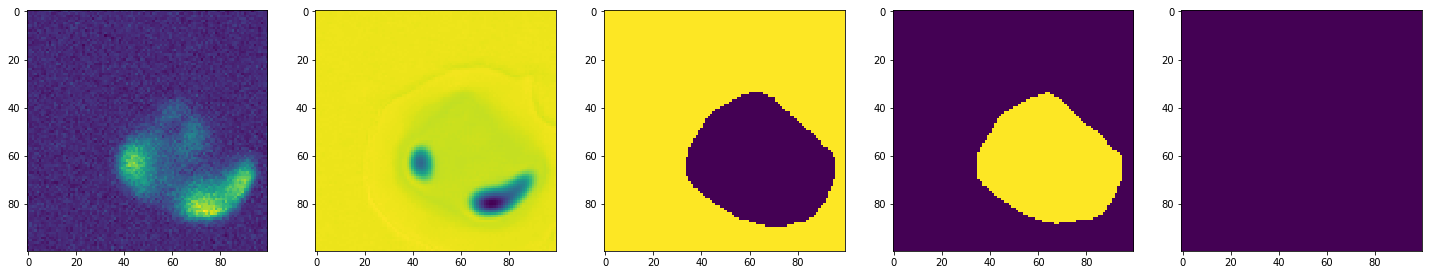

In [53]:
plt.figure(figsize=(25,5))
plt.subplot(1,5,1)
plt.imshow(Y_train[0,200:300,250:350,0])
plt.subplot(1,5,2)
plt.imshow(denoised[200:300,250:350])
plt.subplot(1,5,3)
plt.imshow(seg[200:300,250:350,0]>0.5)
plt.subplot(1,5,4)
plt.imshow(seg[200:300,250:350,1]>0.5)
plt.subplot(1,5,5)
plt.imshow(seg[200:300,250:350,2]>0.5)

## Evaluation

For the evaluation we load the test low-SNR and ground truth data. Since we have simulated low- and high-SNR images via exposure, we have to normalize the values to compute a meaningful PSNR value. The ground truth data has a simulated exposure of 10'000 and the low-SNR data has an exposure of 20. 

In [ ]:
# model.load_weights( name='weights_now.h5')

In [ ]:
test_gt = np.load('data/N2V_exampleData/N2V_gt.npy')
# Normalize exposure
test_gt = test_gt/10000 * 20

In [ ]:
test_lowSNR = np.load('data/N2V_exampleData/N2V_lowSNR.npy')
# normalize data with mean and std of the training data
test_lowSNR = normalize(test_lowSNR, mean, std)

In [ ]:
predictions = []
# Denoise all images
for i in range(test_lowSNR.shape[0]):
    predictions.append(denormalize(model.predict(test_lowSNR[i], axes='YXC',normalizer=None ), mean, std))
predictions = np.array(predictions)

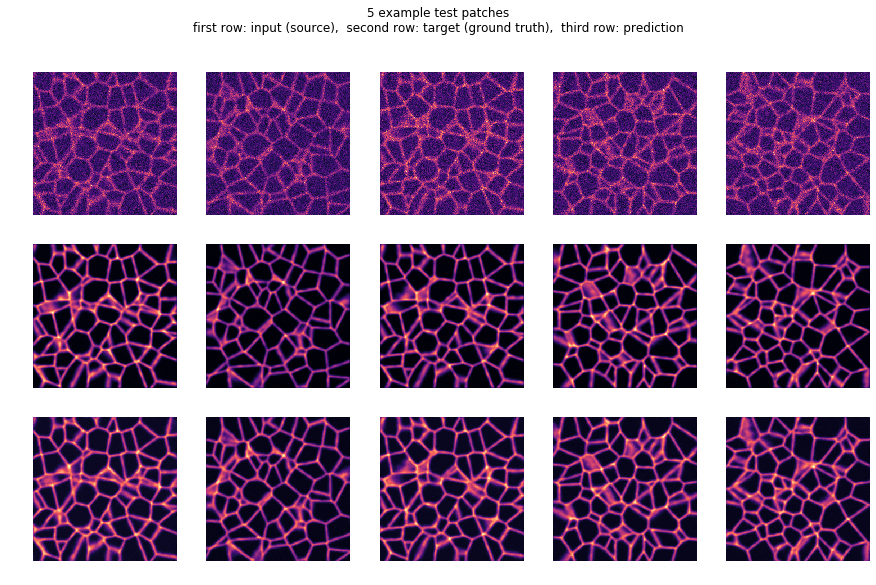

In [13]:
plt.figure(figsize=(15,9))
plot_some(test_lowSNR[:5], test_gt[:5], predictions[:5])
plt.suptitle('5 example test patches\n'      
             'first row: input (source),  '        
             'second row: target (ground truth),  '
             'third row: prediction');

In [14]:
def PSNR(gt, pred, range_):
    mse = np.mean((gt - pred)**2)
    return 20 * np.log10((range_)/np.sqrt(mse))

In [15]:
def stack_PSNR(gt, pred):
    psnr = 0
    min_gt, max_gt = np.min(gt), np.max(gt)
    for i in range(gt.shape[0]):
        psnr += PSNR(gt[i], pred[i], max_gt-min_gt)
    
    return psnr/gt.shape[0]

In [16]:
print('PSNR')
print('Input:', stack_PSNR(test_gt, test_lowSNR))
print('Prediction:', stack_PSNR(test_gt, predictions))

PSNR
Input: 8.761603419810816
Prediction: 31.44227559267284
